In [1]:
!pip install pmdarima > /dev/null

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime,timedelta
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import pmdarima as pm
import pickle
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [2]:
"""#### READ DATASET"""

df = pd.read_csv('/content/data (2).csv')

# Select the columns for forecasting
df = df[['zone','month', 'finished_clients', 'active_clients']]

df['month'] = pd.to_datetime(df['month'], format = '%d/%m/%Y')
df

,zone,month,finished_clients,active_clients
0,Z2,2017-11-01,3,16
1,Z2,2017-11-01,5,9
2,Z2,2017-11-01,16,33
3,Z2,2017-11-01,8,16
4,Z2,2017-11-01,12,19
...,...,...,...,...
5069,Z3,2023-05-01,0,32
5070,Z2,2023-05-01,0,2
5071,Z1,2023-05-01,0,5
5072,Z1,2023-05-01,0,8


**Conducting EDA**

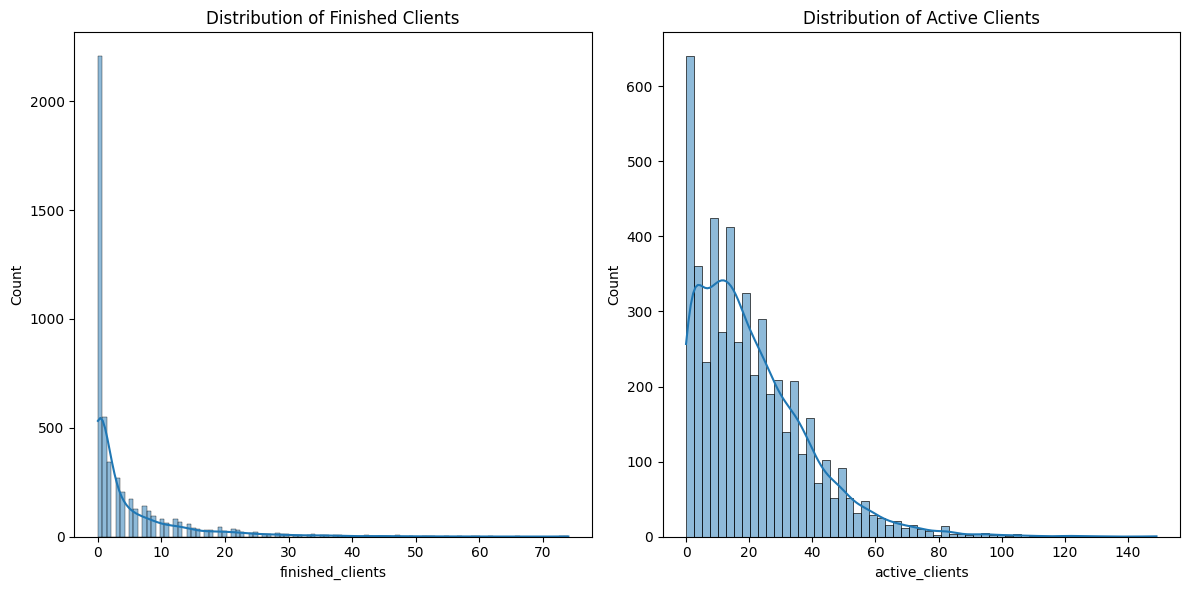

<ipython-input-3-c0599a9d420d>:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_data = df.groupby('year_month').sum()


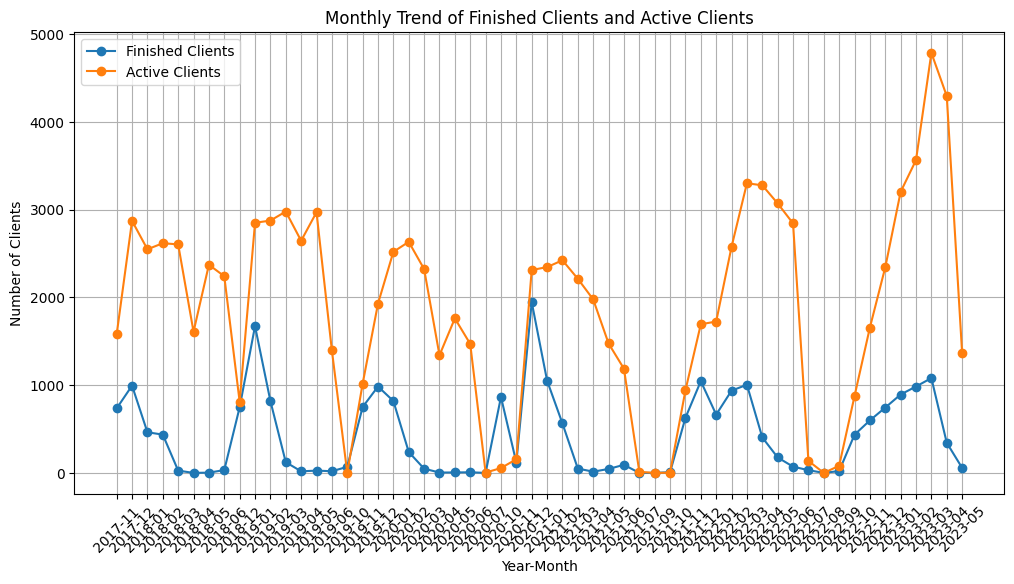

<ipython-input-3-c0599a9d420d>:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='zone', y='finished_clients', ci=None)
<ipython-input-3-c0599a9d420d>:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='zone', y='active_clients', ci=None)


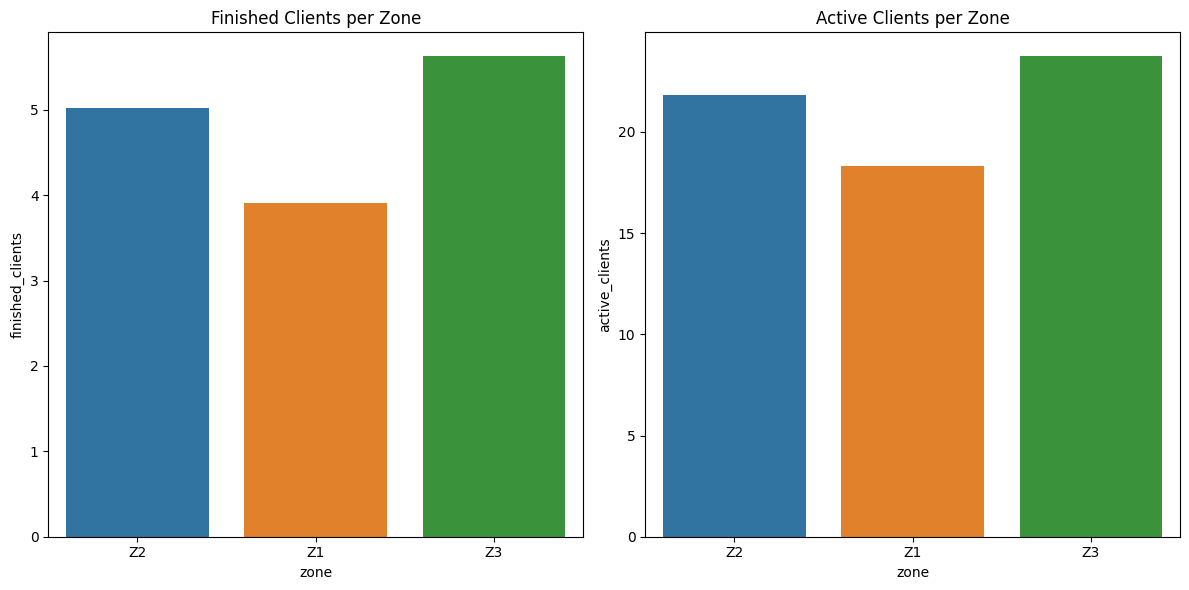

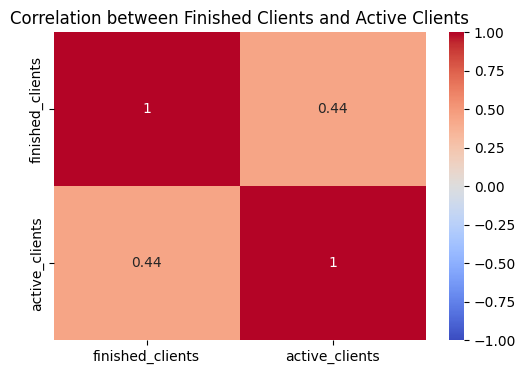

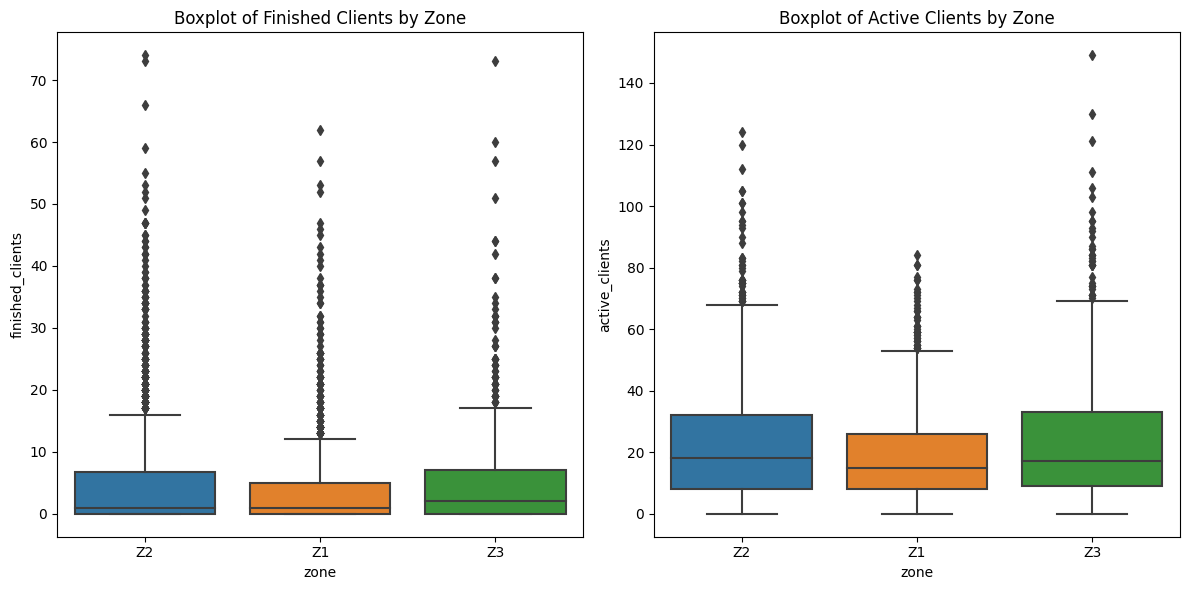

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of finished_clients and active_clients
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['finished_clients'], kde=True)
plt.title('Distribution of Finished Clients')

plt.subplot(1, 2, 2)
sns.histplot(df['active_clients'], kde=True)
plt.title('Distribution of Active Clients')

plt.tight_layout()
plt.show()

# Monthly trend of finished_clients and active_clients
df['year_month'] = df['month'].dt.to_period('M')
monthly_data = df.groupby('year_month').sum()

plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index.astype(str), monthly_data['finished_clients'], marker='o', label='Finished Clients')
plt.plot(monthly_data.index.astype(str), monthly_data['active_clients'], marker='o', label='Active Clients')
plt.xlabel('Year-Month')
plt.ylabel('Number of Clients')
plt.title('Monthly Trend of Finished Clients and Active Clients')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# Zone-wise analysis
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=df, x='zone', y='finished_clients', ci=None)
plt.title('Finished Clients per Zone')

plt.subplot(1, 2, 2)
sns.barplot(data=df, x='zone', y='active_clients', ci=None)
plt.title('Active Clients per Zone')

plt.tight_layout()
plt.show()

# Correlation between Finished Clients and Active Clients
correlation = df[['finished_clients', 'active_clients']].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Finished Clients and Active Clients')
plt.show()

# Boxplot of finished_clients and active_clients by zone
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='zone', y='finished_clients')
plt.title('Boxplot of Finished Clients by Zone')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='zone', y='active_clients')
plt.title('Boxplot of Active Clients by Zone')

plt.tight_layout()
plt.show()



In [4]:
# Identify the zones with the highest and lowest number of finished clients
zone_max = df.groupby('zone')['finished_clients'].sum().idxmax()
zone_min = df.groupby('zone')['finished_clients'].sum().idxmin()
zone_min
zone_max

# Calculate the average number of finished clients per zone
avg_clients_per_zone = df.groupby('zone')['finished_clients'].mean()
avg_clients_per_zone
# Provide recommendations for improving client retention in low-performing zones
#recommendation = "Based on our analysis, Zone {} has the highest number of finished clients, while Zone {} has the lowest. We recommend focusing on the low-performing Zone {}

zone
Z1    3.908526
Z2    5.023631
Z3    5.626374
Name: finished_clients, dtype: float64

**Checking Seasonality**

In [5]:
# Test for Seasonality
def test_seasonality(data):
    result = adfuller(data)
    p_value = result[1]
    
    if p_value <= 0.05:
        return True  # Seasonality exists
    else:
        return False  # Seasonality does not exist

# Test for seasonality in 'finished_clients'
seasonality_finished_clients = test_seasonality(df['finished_clients'])

# Test for seasonality in 'active_clients'
seasonality_active_clients = test_seasonality(df['active_clients'])

print("Seasonality in 'finished_clients':", seasonality_finished_clients)
print("Seasonality in 'active_clients':", seasonality_active_clients)








Seasonality in 'finished_clients': True
Seasonality in 'active_clients': True


**Data Preprocessing and Training of the model**

In [6]:

# Prepare the data for modeling
data = df[['month', 'finished_clients']].copy()
data.set_index('month', inplace=True)

# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

# Scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# SARIMA modeling
model = SARIMAX(train_scaled, order=(1, 1, 1), seasonal_order=(0, 0, 0, 12))
model_fit = model.fit()

# Forecast using SARIMA
predictions_sarima = model_fit.predict(start=len(train_scaled), end=len(train_scaled) + len(test_scaled) - 1)
predictions_sarima = scaler.inverse_transform(predictions_sarima.reshape(-1, 1))

# LSTM modeling
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(64, input_shape=(1, 1)))
    model.add(Dense(1))
    return model

lstm_model = create_lstm_model()
lstm_model.compile(loss='mean_squared_error', optimizer=Adam())
train_scaled_lstm = train_scaled.reshape(-1, 1, 1)
test_scaled_lstm = test_scaled.reshape(-1, 1, 1)
lstm_model.fit(train_scaled_lstm, train_scaled_lstm, epochs=10, batch_size=1, verbose=0)

# Forecast using LSTM
predictions_lstm = lstm_model.predict(test_scaled_lstm)
predictions_lstm = scaler.inverse_transform(predictions_lstm.reshape(-1, 1))

# Calculate RMSE for SARIMA and LSTM
rmse_sarima = np.sqrt(mean_squared_error(test_data, predictions_sarima))
rmse_lstm = np.sqrt(mean_squared_error(test_data, predictions_lstm))

print("RMSE (SARIMA):", rmse_sarima)
print("RMSE (LSTM):", rmse_lstm)


32/32 [==============================] - 1s 2ms/step
RMSE (SARIMA): 7.3404320567292904
RMSE (LSTM): 0.028118909079223365


**Saving the model so that i can be serialized and consumed**

In [7]:
# Save the LSTM model as .h5 file
lstm_model.save('lstm_model.h5')
